#Fetch and clean data

In [1]:
!sh fetch.sh

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2955M  100 2955M    0     0  11.4M      0  0:04:17  0:04:17 --:--:-- 11.6M
Archive:  data/alldata
   creating: data/Second Set/
   creating: data/Second Set/400x OSCC Histopathological Images/
  inflating: data/Second Set/400x OSCC Histopathological Images/OSCC_400x_474.jpg  
  inflating: data/Second Set/400x OSCC Histopathological Images/OSCC_400x_393.jpg  
  inflating: data/Second Set/400x OSCC Histopathological Images/OSCC_400x_159.jpg  
  inflating: data/Second Set/400x OSCC Histopathological Images/OSCC_400x_87.jpg  
  inflating: data/Second Set/400x OSCC Histopathological Images/OSCC_400x_195.jpg  
  inflating: data/Second Set/400x OSCC Histopathological Images/OSCC_400x_357.jpg  
  inflating: data/Second Set/400x OSCC Histopathological Images/OSCC_400x_276.jpg  
  inflating: data/Second Set/400x OSCC Histopathological I

# Installation and Importing

In [2]:
!pip install git+https://github.com/fastai/fastai;
!pip install git+https://github.com/fastai/fastcore;

  Cloning https://github.com/fastai/fastai to /tmp/pip-req-build-oh60exe6
  Running command git clone -q https://github.com/fastai/fastai /tmp/pip-req-build-oh60exe6
     |████████████████████████████████| 40kB 1.5MB/s 
  Created wheel for fastai: filename=fastai-2.0.14-cp36-none-any.whl size=184607 sha256=2a0f28454d81bd0492029c3f7ea156bbb83053a1081bb06c6279a64c36d765e6
  Stored in directory: /tmp/pip-ephem-wheel-cache-jr05jc4c/wheels/83/30/a0/6fa8a74c9f5a5ab45cdc84e9f9ed56d8a72750e11ebf50a364
Successfully built fastai
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
  Cloning https://github.com/fastai/fastcore to /tmp/pip-req-build-xo39yah5
  Running command git clone -q https://github.com/fastai/fastcore /tmp/pip-req-build-xo39yah5
  Created wheel for fastcore: filename=fastcore-1.0.14-cp36-none-any.whl size=40771 sha256=0339e230fea0dc0f116feaff7cca209cc62c7a3ef38d1825521b25ffd24c1d62
  Stored in directory: /tmp

In [15]:
from fastai.vision.all import *
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, recall_score
from tqdm import tqdm

#Set Default values and random seed

In [7]:
DATA_PATH = Path('data/images')

IMG_SIZE = 800
SEED = 22
N_FOLDS = 5
BS = 16
N_FOLDS = 5

ARCH = resnet18

In [8]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(SEED)

#Create Dataframe For Kfold Cross Validation

In [9]:
filenames = [str(x).split('/')[-1] for x in (DATA_PATH).ls()]
dataframe = pd.DataFrame(data=filenames, columns=['Filenames'])
dataframe.loc[:, 'Target'] =  dataframe.loc[:, 'Filenames'].str.split('_').str[0]

In [10]:
dataframe.loc[:, 'Target'].value_counts()

OSCC      934
Normal    290
Name: Target, dtype: int64

In [11]:
dataframe['fold'] = -1

skf = StratifiedKFold(n_splits=N_FOLDS, random_state=SEED, shuffle=True)
for i, (_, test_index) in enumerate(skf.split(dataframe.loc[:, 'Filenames'].values, dataframe.loc[:, 'Target'].values)):
    dataframe.iloc[test_index, -1] = i
    
dataframe['fold'] = dataframe['fold'].astype('int')

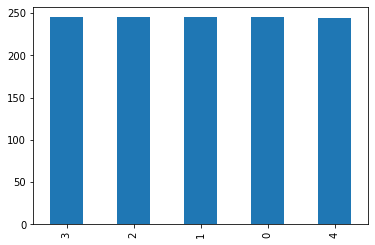

In [12]:
dataframe.loc[:, 'fold'].value_counts().plot.bar();

#Checking Image sizes

In [ ]:
DATA_PATH/dataframe.loc[0, 'Filenames']

Path('/content/data/images/OSCC_100x_14.jpg')

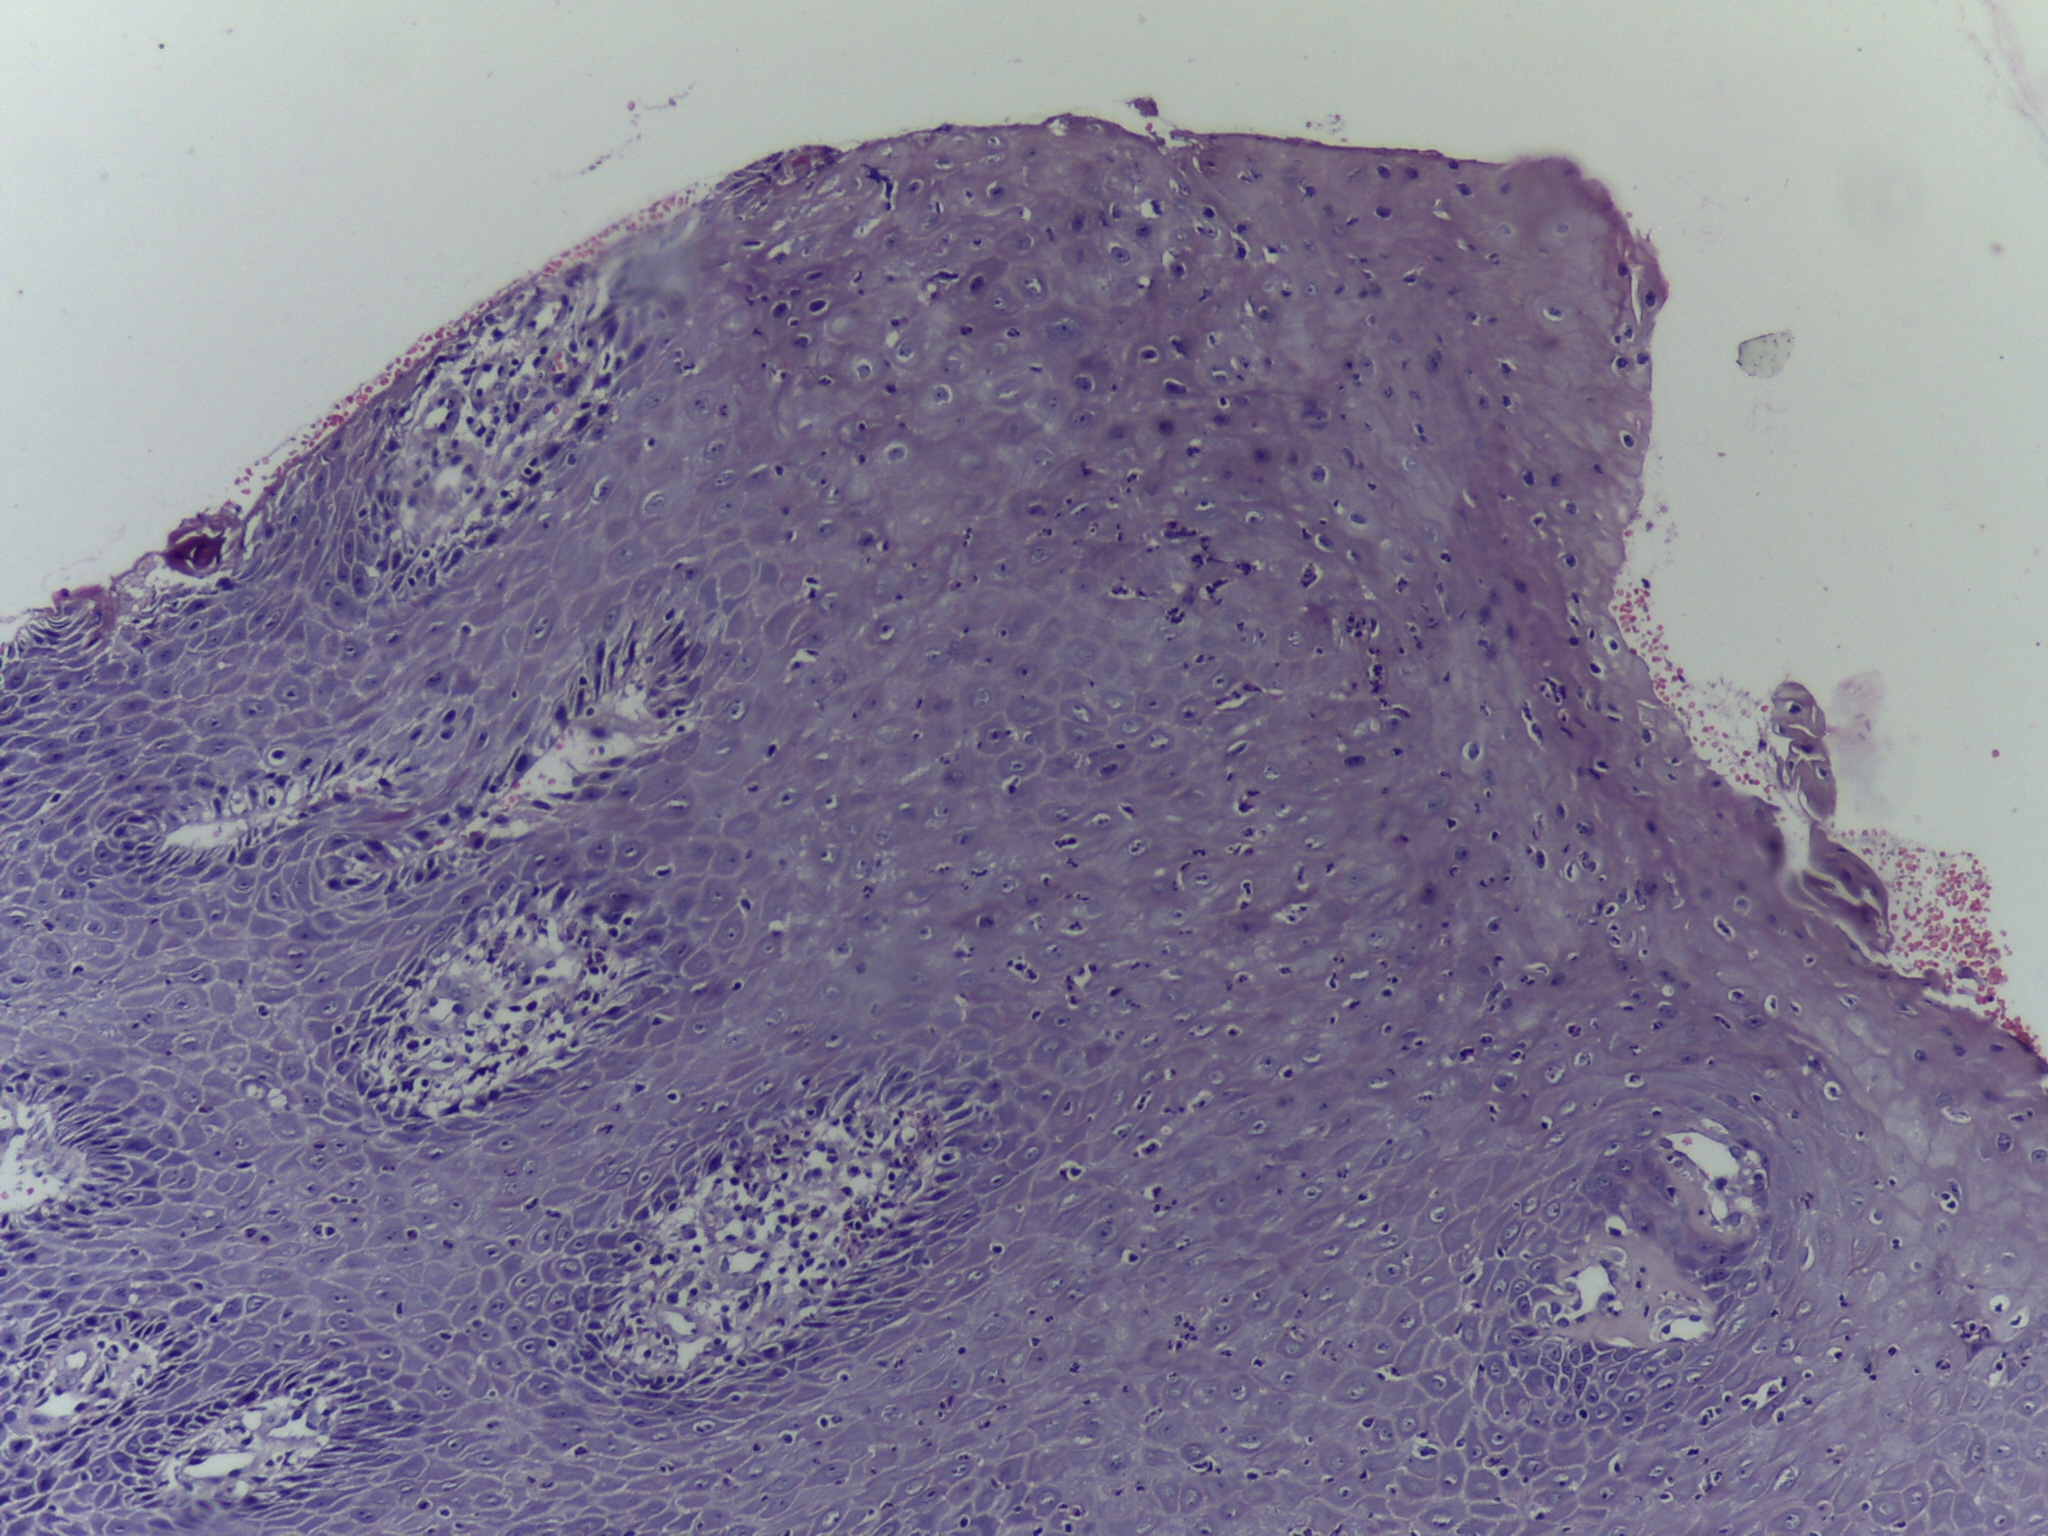

In [ ]:
Image.open(DATA_PATH/dataframe.loc[0, 'Filenames'])

In [ ]:
image = Image.open(DATA_PATH/dataframe.loc[0, 'Filenames'])
height, width = image.size
print(height, width)

2048 1536


In [ ]:
heights, widths = [], []
for _, row in tqdm(dataframe.iterrows(), total=dataframe.shape[0]):
  image = Image.open(DATA_PATH/(row.Filenames))
  height, width = image.size
  heights.append(height)
  widths.append(width)

100%|██████████| 1224/1224 [00:00<00:00, 2732.53it/s]


In [ ]:
min(heights), max(heights), min(widths), max(widths)

(1435, 2048, 916, 2048)

In [ ]:
np.mean(heights), np.mean(widths)

(1947.9436274509803, 1635.049019607843)

In [ ]:
# tfms = setup_aug_tfms([Rotate(draw=30, p=1, size=224), Zoom(draw=1.2, p=1., size=IMG_SIZE),
#                        Warp(draw_x=-0.2, draw_y=0.2, p=1., size=IMG_SIZE)],
#                       )

# Utility Functions

In [25]:
def get_data(fold, prog_resize=1):

  datablock = DataBlock(
          blocks=(ImageBlock, CategoryBlock),
          getters=[
              ColReader('Filenames', pref=DATA_PATH),
              ColReader('Target')
          ],
          splitter=IndexSplitter(dataframe.loc[dataframe.fold==0].index),
          item_tfms=Resize(IMG_SIZE),
          batch_tfms=aug_transforms(size=IMG_SIZE*prog_resize, max_rotate=360., min_scale=0.75, flip_vert=True, do_flip=True)
      )
  return datablock.dataloaders(dataframe, bs=BS)


def get_learner(fold_num, lr=1e-3, prog_resize=1):

  opt_func = partial(Adam, lr=lr, wd=0.01, eps=1e-8)

  dls = get_data(fold_num, prog_resize=prog_resize)

  learn = cnn_learner(
        dls, ARCH, opt_func=opt_func,
        loss_func=LabelSmoothingCrossEntropy(),
        #callback_fns = [partial(OverSamplingCallback)],  
        metrics=[Recall(average='micro'), Precision(average='micro'),
                 F1Score(average='micro'), RocAucBinary(average='micro')]
        ).to_fp16()
  return learn


def scorer(all_val_preds, all_val_labels):
    recalls, precisions, rocaucs, f1s = [], [], [], []
    for val_pred, val_label in zip(all_val_preds, all_val_labels):
        val_pred_armax = torch.argmax(val_pred, dim=1)
        recalls.append(recall(val_pred_armax, val_label))
        precisions.append(precision(val_pred_armax, val_label))
        rocaucs.append(rocauc(val_pred[:, 1], val_label))
        f1s.append(f1(val_pred_armax, val_label))
    return recalls, precisions, rocaucs, f1s

# Test the Get data function

In [ ]:
dls = get_data(1)

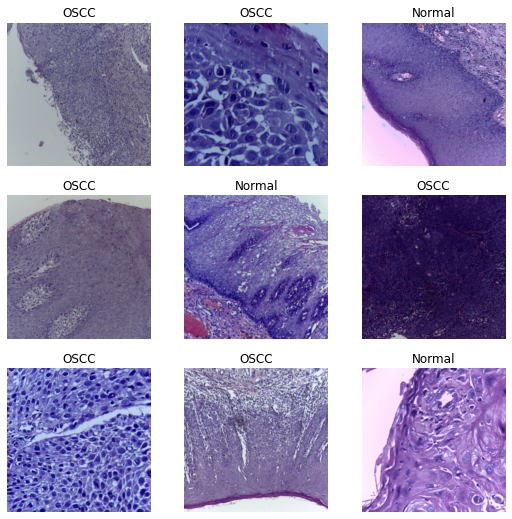

In [ ]:
dls.show_batch()

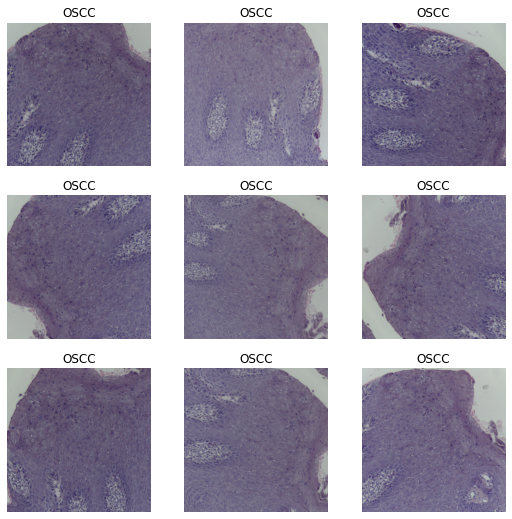

In [ ]:
dls.show_batch(unique=true)

In [ ]:
len(dls.train_ds), len(dls.valid_ds)

(979, 245)

In [ ]:
dls.train_ds.items['Target'].value_counts()

OSCC      747
Normal    232
Name: Target, dtype: int64

In [ ]:
dls.train_ds.items['Target'].value_counts(normalize=True)

OSCC      0.763023
Normal    0.236977
Name: Target, dtype: float64

In [ ]:
dls.valid_ds.items['Target'].value_counts(normalize=True)

OSCC      0.763265
Normal    0.236735
Name: Target, dtype: float64

#Training

In [ ]:
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


SuggestedLRs(lr_min=0.0006309573538601399, lr_steep=1.9054607491852948e-06)

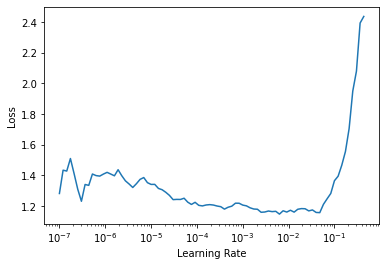

In [ ]:
get_learner(fold_num=0).lr_find()

In [26]:
all_val_preds = []
all_val_labels = []

for i in range(2):
    print(f'Fold {i} results')

    learn = get_learner(fold_num=i)

    learn.fit_one_cycle(2, 1e-2)
    learn.unfreeze()

    learn.fit_one_cycle(1, slice(1e-5, 1e-4))
    
    # learn.recorder.plot_loss()
        
    # learn.freeze()
    
    # learn.data = get_learner(i, prog_resize=2)
    
    # lr_min,_ = learn.lr_find()
    
    # learn.fit_one_cycle(1, slice(lr_min))

    learn.save(f'model_fold_{i}')
    
    val_preds, val_labels = learn.get_preds()
    
    all_val_preds.append(val_preds)
    all_val_labels.append(val_labels)

    # interp = ClassificationInterpretation.from_learner(learn)
    # interp.plot_confusion_matrix(normalize=False, figsize=(6, 6))

Fold 0 results


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


AssertionError: ignored

In [ ]:
list(zip(learn.recorder.metric_names[2:-1], learn.recorder.values[0][0:]))

[('valid_loss', 0.501726508140564),
 ('recall_score', 0.8367346938775511),
 ('precision_score', 0.8367346938775511),
 ('f1_score', 0.8367346938775511)]

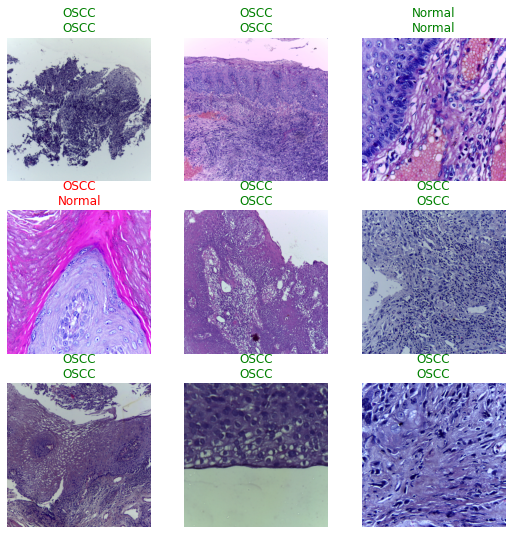

In [ ]:
learn.recorder.show_results()

In [ ]:
recall = Recall(average='micro')
precision = Precision(average='micro')
rocauc = RocAucBinary(average='micro')
f1 = F1Score(average='micro')

In [ ]:
recalls, precisions, rocaucs, f1s = scorer(all_val_preds, all_val_labels)
print(recalls)
print(precisions)
print(rocaucs)
print(f1s)

In [ ]:
# def scorer(all_val_preds, all_val_labels):
#   recalls, precisions, rocaucs, f1s = [], [], [], []
#   for val_pred, val_label in zip(all_val_preds, all_val_labels):
#     val_pred_armax = torch.argmax(val_pred, dim=1)
#     recalls.append(recall(val_pred_armax, val_label))
#     precisions.append(precision(val_pred_armax, val_label))
#     rocaucs.append(rocauc(val_pred[:, 1], val_label))
#     f1s.append(f1(val_pred_armax, val_label))
#   return recalls, precisions, rocaucs, f1s

In [ ]:
# recalls, precisions, rocaucs, f1s = [], [], [], []
# for val_pred, val_label in zip(all_val_preds, all_val_labels):
#   val_pred_armax = torch.argmax(val_pred, dim=1)
#   recalls.append(recall(val_pred_armax, val_label))
#   precisions.append(precision(val_pred_armax, val_label))
#   rocaucs.append(rocauc(val_pred[:, 1], val_label))
#   f1s.append(f1(val_pred_armax, val_label))

#Interpretation

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

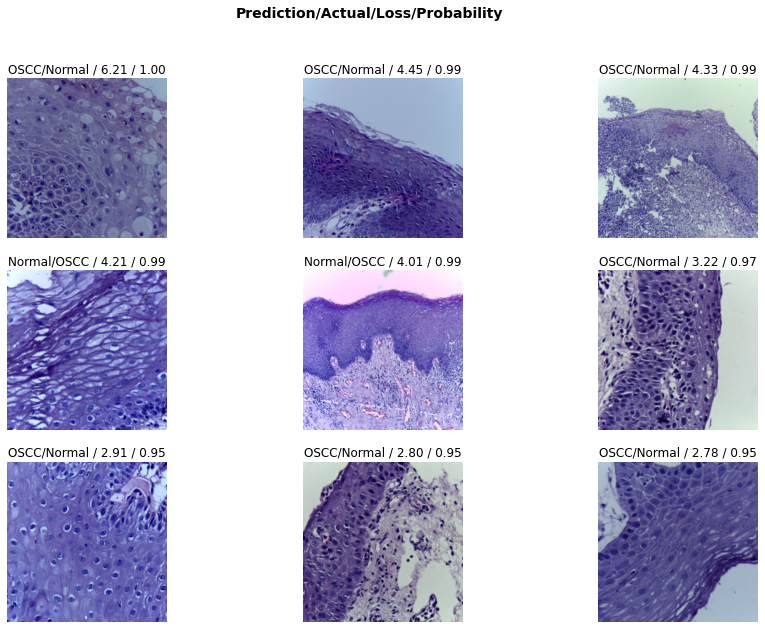

In [ ]:
interp.plot_top_losses(9, figsize=(15, 10))

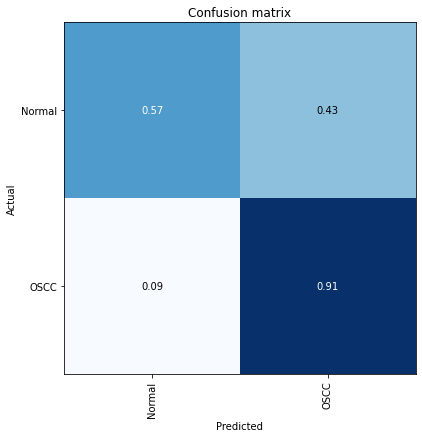

In [ ]:
interp.plot_confusion_matrix(normalize=True, figsize=(6, 6))

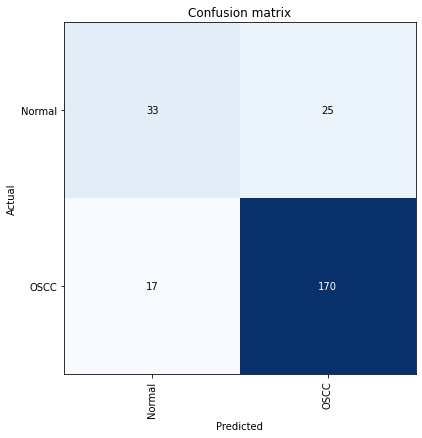

In [ ]:
interp.plot_confusion_matrix(normalize=False, figsize=(6, 6))

# REFERENCES

In [ ]:
# https://data.mendeley.com/datasets/ftmp4cvtmb/1

In [ ]:
# https://docs.fast.ai/
# https://github.com/fastai/fastbook/blob/master/clean/
# https://www.mdpi.com/2078-2489/11/2/108

In [ ]:
# learning rate finder
# @misc{smith2015cyclical,
#     title={Cyclical Learning Rates for Training Neural Networks},
#     author={Leslie N. Smith},
#     year={2015},
#     eprint={1506.01186},
#     archivePrefix={arXiv},
#     primaryClass={cs.CV}
# }